Dataset shape: (225745, 79)
Using sample of 10000 rows
eps=0.3: 73 clusters, 3257 noise points
eps=0.5: 67 clusters, 2408 noise points
eps=0.7: 58 clusters, 1983 noise points
eps=1.0: 44 clusters, 1430 noise points

Evaluasi berbagai nilai eps:
   eps  n_clusters  noise_points  silhouette
0  0.3          73          3257    0.183371
1  0.5          67          2408    0.298716
2  0.7          58          1983    0.266322
3  1.0          44          1430    0.413793

Menggunakan eps terbaik = 1.0
Hasil disimpan ke dbscan_results_sample.csv

Cluster vs Label:
Label    BENIGN  DDoS
cluster              
-1         1132   298
 0          104  2103
 1          580     0
 2            0  2318
 3            0   546
 4          729     0
 5            0   282
 6          540     0
 7           21     0
 8            0    88
 9           18     0
 10          69     0
 11          32     0
 12          20     0
 13         133     0
 14         140     0
 15          18     0
 16          21   

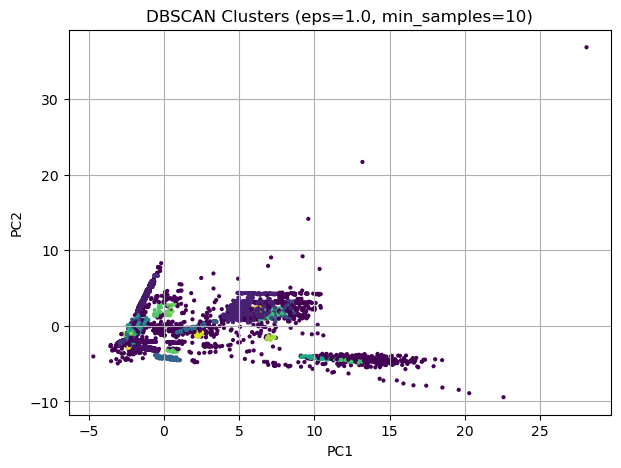

In [1]:
# DBSCAN Clustering (Step-by-Step)
# Dataset: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
# Requirements:
# pip install pandas scikit-learn matplotlib numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# ---------------- CONFIG ----------------
FILE_PATH = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
SAMPLE_N = 10000        # gunakan subset untuk efisiensi
RANDOM_STATE = 42
EPS_VALUES = [0.3, 0.5, 0.7, 1.0]   # kandidat eps
MIN_SAMPLES = 10
# ----------------------------------------

# 1) Load & cleaning
df = pd.read_csv(FILE_PATH)
df.columns = df.columns.str.strip()
label_col = "Label" if "Label" in df.columns else None
print("Dataset shape:", df.shape)

# 2) Pilih fitur numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if label_col and label_col in num_cols:
    num_cols.remove(label_col)

df_num = df[num_cols].copy()
df_num.replace([np.inf, -np.inf], np.nan, inplace=True)
df_num.fillna(df_num.median(), inplace=True)

# 3) Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

# 4) Sampling
n_total = X_scaled.shape[0]
if SAMPLE_N < n_total:
    np.random.seed(RANDOM_STATE)
    idx = np.random.choice(n_total, SAMPLE_N, replace=False)
    X_sample = X_scaled[idx]
    labels_sample = df[label_col].iloc[idx] if label_col else None
else:
    X_sample = X_scaled
    labels_sample = df[label_col] if label_col else None

print(f"Using sample of {X_sample.shape[0]} rows")

# 5) Coba beberapa nilai eps untuk melihat seberapa banyak noise
results = []
for eps in EPS_VALUES:
    db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES, n_jobs=-1)
    preds = db.fit_predict(X_sample)
    n_clusters = len(set(preds)) - (1 if -1 in preds else 0)
    n_noise = list(preds).count(-1)
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")
    
    if n_clusters > 1:
        sil = silhouette_score(X_sample, preds)
    else:
        sil = np.nan
    results.append((eps, n_clusters, n_noise, sil))

# 6) Tampilkan hasil coba
res_df = pd.DataFrame(results, columns=["eps", "n_clusters", "noise_points", "silhouette"])
print("\nEvaluasi berbagai nilai eps:")
print(res_df)

# 7) Pilih eps terbaik (contoh: dengan silhouette tertinggi)
best_row = res_df.loc[res_df["silhouette"].idxmax()]
best_eps = best_row["eps"]
print(f"\nMenggunakan eps terbaik = {best_eps}")

# 8) Jalankan DBSCAN dengan eps terbaik
db_final = DBSCAN(eps=best_eps, min_samples=MIN_SAMPLES, n_jobs=-1)
preds_final = db_final.fit_predict(X_sample)

# 9) Simpan hasil
df_out = pd.DataFrame(X_sample)
df_out["cluster"] = preds_final
if label_col:
    df_out["Label"] = labels_sample.values

df_out.to_csv("dbscan_results_sample.csv", index=False)
print("Hasil disimpan ke dbscan_results_sample.csv")

# 10) Analisis hasil
if label_col:
    print("\nCluster vs Label:")
    print(pd.crosstab(df_out["cluster"], df_out["Label"]))
    print("\nProporsi per cluster:")
    print(pd.crosstab(df_out["cluster"], df_out["Label"], normalize="index"))

# 11) Visualisasi PCA (2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=preds_final, s=4, cmap="viridis")
plt.title(f"DBSCAN Clusters (eps={best_eps}, min_samples={MIN_SAMPLES})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()
